In [16]:
import numpy	as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp

In [17]:
datos = pd.read_csv('data.csv')
magnitud = datos.iloc[:, 0]
funcionlum = datos.iloc[:, 1]

In [18]:
def	schechter(x,M,phi,alpha):
				m = 0.4*np.log(10)*phi*(10**(-0.4*(x-M)*(alpha+1)))*np.exp(-10**(-0.4*(x-M)))
				return m

Derivo con python para evitar errores humanos

In [19]:
x, M, phi, alpha = sp.symbols('x M phi alpha')
m_sympy = 0.4*sp.log(10)*phi*(10**(-0.4*(x-M)*(alpha+1)))*sp.exp(-10**(-0.4*(x-M)))
derivadaM = sp.diff(m_sympy, M)
derivadaphi = sp.diff(m_sympy, phi)
derivadaalpha = sp.diff(m_sympy, alpha)
print(derivadaM)
print(derivadaphi)
print(derivadaalpha)

-0.16*10**((0.4*M - 0.4*x)*(alpha + 1))*10**(0.4*M - 0.4*x)*phi*exp(-10**(0.4*M - 0.4*x))*log(10)**2 + 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*alpha + 0.4)*exp(-10**(0.4*M - 0.4*x))*log(10)**2
0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*exp(-10**(0.4*M - 0.4*x))*log(10)
0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*M - 0.4*x)*exp(-10**(0.4*M - 0.4*x))*log(10)**2


In [20]:
fiducial_M = -20.83
fiducial_phi = 1.46e-2
fiducial_alpha = -1.2

alphamin = fiducial_alpha*(1+0.1)
alphamax = fiducial_alpha*(1-0.1)
Mmin = fiducial_M*(1+0.1)
Mmax = fiducial_M*(1-0.1)
phimin = fiducial_phi*(1-0.2)
phimax = fiducial_phi*(1+0.2)
print(alphamin, alphamax, Mmin, Mmax, phimin, phimax)

def loglike(x, y, M, phi, alpha, sigma):
				m = schechter(x, M, phi, alpha)
				L = -(1/2) * np.sum(((y - m) / sigma) ** 2)
				return L

bordeinferr =	np.array([Mmin, phimin, alphamin])
bordesuperr = np.array([Mmax, phimax, alphamax])

def priors(params):
	if np.all(bordeinferr <= params) and np.all(params <= bordesuperr):
		return 0
	else:
		return -np.inf
	

def post(x, y, M, phi, alpha, sigma):
	params = np.array([M, phi, alpha])
	prior_prob = priors(params)
	return loglike(x, y, M, phi, alpha, sigma) + prior_prob

def normM(M):
    return (M - Mmin) / ( Mmax - Mmin)

def anti_normM(M):
				return (M * (Mmax - Mmin)) + Mmin

def normphi(phi):
				return (phi - phimin) / (phimax - phimin)

def anti_normphi(phi):
				return (phi * (phimax - phimin)) + phimin

def normalpha(alpha):
				return (alpha - alphamin) / (alphamax - alphamin)

def anti_normalpha(alpha):
				return (alpha * (alphamax - alphamin)) + alphamin

-1.32 -1.08 -22.913 -18.747 0.011680000000000001 0.01752


Definimos las funciones

In [21]:
def diffM(x,	M, phi, alpha):
				return -0.16*10**((0.4*M - 0.4*x)*(alpha + 1))*10**(0.4*M - 0.4*x)*phi*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)**2 + 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*alpha + 0.4)*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)**2


def diffphi(x,	M, phi, alpha):
				return 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)

def diffalpha(x,	M, phi, alpha):
				return 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*M - 0.4*x)*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)**2

def gradiente(x, M, phi, alpha, sigma):
				grad = np.zeros(3)
				grad[0] = -2*np.sum((funcionlum-schechter(magnitud, M, phi, alpha))*diffM(magnitud, M, phi, alpha)/(sigma**2))
				grad[1] = -2*np.sum((funcionlum-schechter(magnitud, M, phi, alpha))*diffphi(magnitud, M, phi, alpha)/(sigma**2))
				grad[2] = -2*np.sum((funcionlum-schechter(magnitud, M, phi, alpha))*diffalpha(magnitud, M, phi, alpha)/(sigma**2))
				return grad

Ahora si, el descenso por el gradiente

In [22]:
def graddes(x, y, sigma, N):
	#Lanzamos en un lugar al azar dentro de los priors.
	M = -20.528749669717794
	phi = 0.014099700887138394
	alpha = -1.1162915383414187
	#Armamos las listas donde guardaremos todo
	Mreccorridos	= np.zeros(N+1)
	phirecorridos = np.zeros(N+1)
	alpharecorridos = np.zeros(N+1)
	probrecorridas = np.zeros(N+1)
	#Guardamos los primeros valores
	Mreccorridos[0] = M
	phirecorridos[0] = phi
	alpharecorridos[0] = alpha
	probrecorridas[0] = post(x, y, M, phi, alpha, sigma)
	#Empezamos a recorrer
	for i in range(N):
		if i<N/10:
			pp = 1e-2
		elif i<(2*N/10):
			pp =	1e-3
		else:
			pp = 1e-4

		#Calculamos el gradiente y lo normalizamos
		grad =	gradiente(x, M, phi, alpha, sigma)
		gradnorm	= np.zeros(3)
		for j in range(3):
			gradnorm[j]	= grad[j]/np.sqrt(grad[0]**2 + grad[1]**2 + grad[2]**2)
		
		M_paso = normM(M) - gradnorm[0]*pp
		phi_paso = normphi(phi) - gradnorm[1]*pp
		alpha_paso = normalpha(alpha) - gradnorm[2]*pp
		
		#Ahora, desonormalizamos para calcular la probabilidad:
		M_paso = anti_normM(M_paso)
		phi_paso = anti_normphi(phi_paso)
		alpha_paso = anti_normalpha(alpha_paso)
		probrecorridas[i+1] = post(x, y, M_paso, phi_paso, alpha_paso, sigma)
	#Me los guardo en la lista
		Mreccorridos[i+1] = M_paso
		phirecorridos[i+1] = phi_paso
		alpharecorridos[i+1] = alpha_paso
		#Avanzo
		M = M_paso
		phi = phi_paso
		alpha = alpha_paso
	#Obtengo todos los valores de los parametros
	return	Mreccorridos, phirecorridos, alpharecorridos, probrecorridas

In [23]:
def mc(x, y, sigma, N):
	
	#Lanzamos en un lugar al azar dentro de los priors.
	M = -20.528749669717794
	phi = 0.014099700887138394
	alpha = -1.1162915383414187
	
	print('Initial values: ', M, phi, alpha)

	#Armamos las listas donde guardaremos todo
	Mreccorridos = np.zeros(N+1)
	phirecorridos = np.zeros(N+1)
	alpharecorridos = np.zeros(N+1)
	p = np.zeros(N+1)
	
	#Calculamos el primer valor de la probabilidad
	p[0] = post(x, y, M, phi, alpha, sigma)
	print(p[0])
	
	#Guardamos los primeros valores
	Mreccorridos[0] = M
	phirecorridos[0] = phi
	alpharecorridos[0] = alpha
	
	#Empezamos a recorrer
	for i in range(1,N+1):

		#Damos pasos inversamente proporcionales a la probabilidad, de modo que sean largos lejos del pico, y cortos cerca del pico.
		if i <	1000:
			pp	= 1e-1
		elif i < 3000:
			pp = 1e-2
		else:
			pp = 1e-3

		M_paso = normM(M) + np.random.uniform(-1,1)*pp
		phi_paso = normphi(phi) + np.random.uniform(-1,1)*pp
		alpha_paso = normalpha(alpha) + np.random.uniform(-1,1)*pp
		
		#Ahora, desonormalizamos para calcular la probabilidad:
		M_paso = anti_normM(M_paso)
		phi_paso = anti_normphi(phi_paso)
		alpha_paso = anti_normalpha(alpha_paso)

		#Ahora, si la probabilidad del paso es mayor a la probabilidad actual, nos movemos a ese paso.
		current_post = post(x, y, M_paso, phi_paso, alpha_paso, sigma)
		dif = current_post - p[i-1]
		print(dif)
		ran = np.log(np.random.uniform(0,1))
		if  dif > ran:
			M = M_paso
			phi = phi_paso
			alpha = alpha_paso
		
		Mreccorridos[i] = M
		phirecorridos[i] = phi
		alpharecorridos[i] = alpha
		p[i] = post(x, y, M, phi, alpha, sigma)

	#Obtengo todos los valores de los parametros
	return	Mreccorridos, phirecorridos, alpharecorridos, p

In [24]:
erromin = datos.iloc[:,2]
erromax = datos.iloc[:,3]

sigma = (erromax-erromin) / 2

# Ejecutar el descenso por gradiente
mrec, phirec, alpharec, p = graddes(magnitud, funcionlum, sigma, 10000)

In [25]:
#Ejecutar mc

mcaden , phicaden, alphacaden, pcaden = mc(magnitud, funcionlum, sigma, 10000)

Initial values:  -20.528749669717794 0.014099700887138394 -1.1162915383414187
-97819.78467863251
65379.335213203245
8741.082081796914
-76300.1393476205
-409916.41554410284
-359428.930183215
-732151.5113565546
-410975.91872188175
-43764.37452614332
-419813.6256597293
-775390.9129769215
-634384.3186293223
-125932.38198731226
-170251.7565364119
-55394.01736216417
-40949.559639957006
-266679.534661584
-106980.74979471428
-130258.37287825695
7056.545611507747
-54305.73616275104
-177948.86648800495
-1529.9344591177578
-120912.9576639495
-42970.20096688875
-252548.15729780644
-508393.16346383456
7000.4987960074195
-82955.94352196495
-1392.4712121729353
-83634.87659905916
-335886.14442166925
-12073.445368115123
-62952.18738588676
-6839.566514282213
-623429.642423283
-117684.04000671365
-404038.8653479368
-560964.5882545083
-109447.29369265535
-596335.6857418802
-79863.2042595744
-24843.645375087508
-337188.9991272159
-19797.60489105672
-18149.92243934478
-623623.3778158322
-33111.74830601935
-

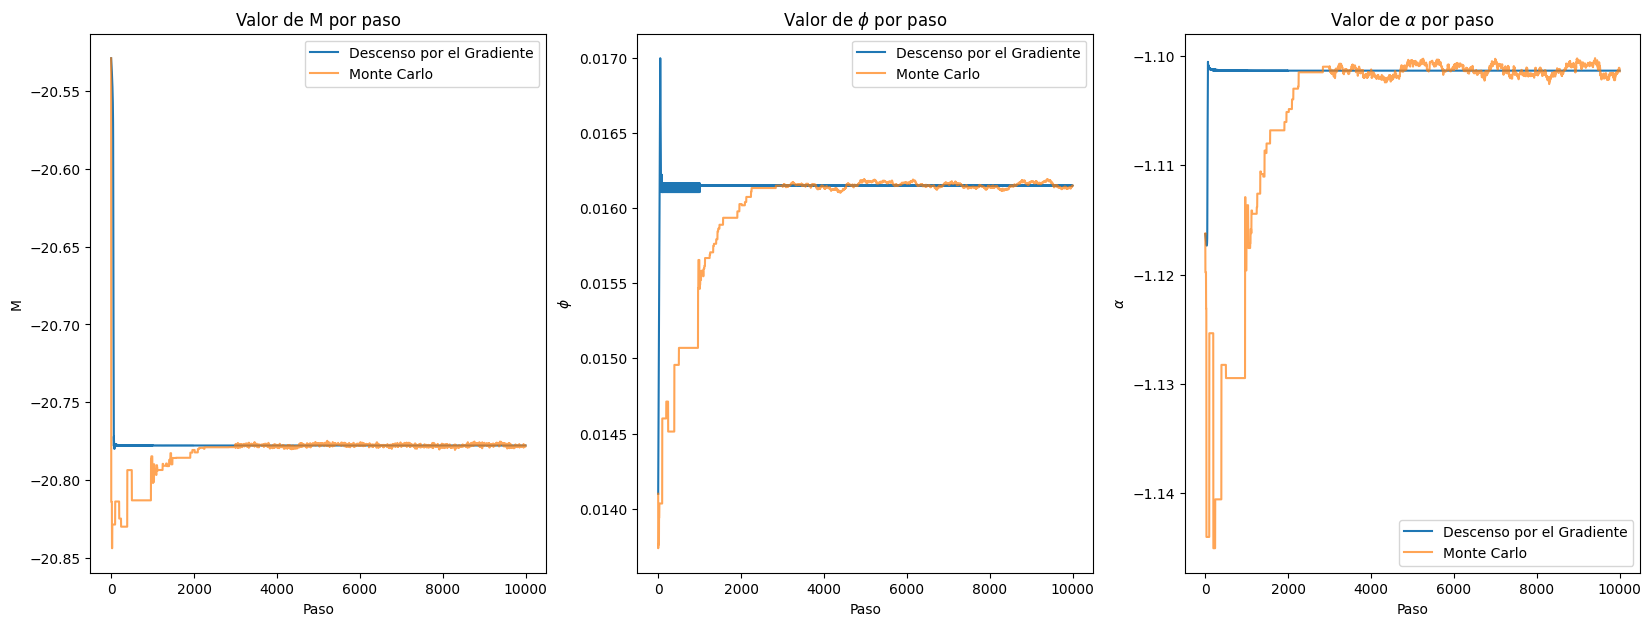

-20.777899984211555 0.016149162080956916 -1.1013395529672656
3.857882504431531e-14 9.715865422194618e-16 1.141518798692617e-15


In [26]:
f, axs = plt.subplots(1, 3, figsize=(20, 7))

# Valor por cada paso
axs[0].plot(mrec, label='Descenso por el Gradiente')
axs[0].plot(mcaden, label='Monte Carlo', alpha=0.7)
axs[0].set_xlabel('Paso')
axs[0].set_ylabel('M')
axs[0].set_title('Valor de M por paso')
axs[0].legend()

axs[1].plot(phirec, label='Descenso por el Gradiente')
axs[1].plot(phicaden, label='Monte Carlo', alpha=0.7)
axs[1].set_xlabel('Paso')
axs[1].set_ylabel('$\phi$')
axs[1].set_title('Valor de $\phi$ por paso')
axs[1].legend()

axs[2].plot(alpharec, label='Descenso por el Gradiente')
axs[2].plot(alphacaden, label='Monte Carlo', alpha=0.7)
axs[2].set_xlabel('Paso')
axs[2].set_ylabel('$\\alpha$')
axs[2].set_title('Valor de $\\alpha$ por paso')
axs[2].legend()

plt.show()


Mmed = np.mean(mrec[-8000:])
phimed = np.mean(phirec[-8000:])
alphamed = np.mean(alpharec[-8000:])
print(Mmed, phimed, alphamed)

Mvari	= np.var(mrec[-8000:])
phivari = np.var(phirec[-8000:])
alphavari = np.var(alpharec[-8000:])

Merror = Mvari/np.sqrt(8000)
phierror = phivari/np.sqrt(8000)
alphaerror = alphavari/np.sqrt(8000)
print(Merror, phierror, alphaerror)


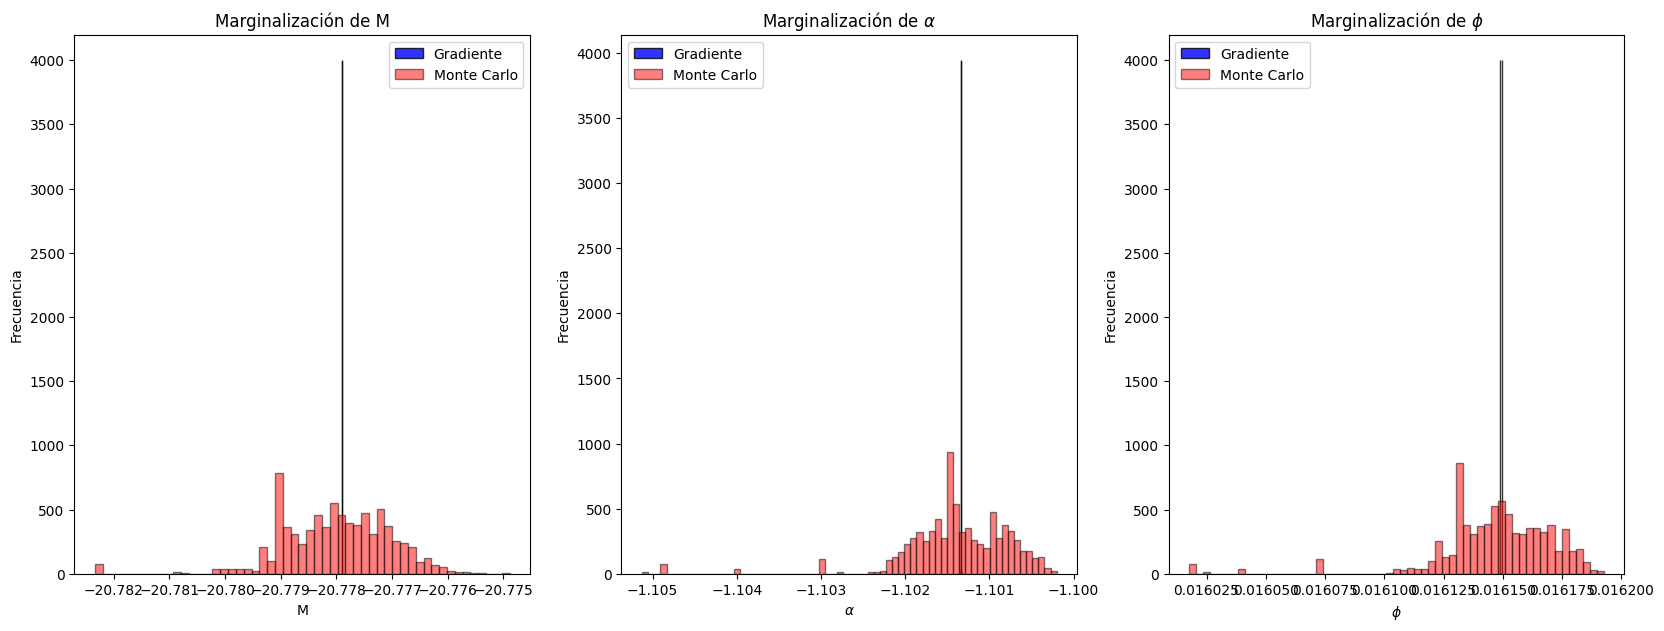

In [27]:
f, axs = plt.subplots(1, 3, figsize=(20, 7))

# Histograma de M
axs[0].hist(mrec[-8000:], color='blue', alpha=0.8, edgecolor='black', bins='auto', label='Gradiente')
axs[0].hist(mcaden[-8000:], color='red', alpha=0.5, edgecolor='black', bins='auto', label='Monte Carlo')
axs[0].set_xlabel('M')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Marginalización de M')
axs[0].legend()

# Histograma de alpha
axs[1].hist(alpharec[-8000:], color='blue', alpha=0.8, edgecolor='black', bins='auto', label='Gradiente')
axs[1].hist(alphacaden[-8000:], color='red', alpha=0.5, edgecolor='black', bins='auto', label='Monte Carlo')
axs[1].set_xlabel('$\\alpha$')
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Marginalización de $\\alpha$')
axs[1].legend()

# Histograma de phi
axs[2].hist(phirec[-8000:], color='blue', alpha=0.8, edgecolor='black', bins='auto', label='Gradiente')
axs[2].hist(phicaden[-8000:], color='red', alpha=0.5, edgecolor='black', bins='auto', label='Monte Carlo')
axs[2].set_xlabel('$\\phi$')
axs[2].set_ylabel('Frecuencia')
axs[2].set_title('Marginalización de $\\phi$')
axs[2].legend()

plt.show()


In [28]:
# Calcular promedios y varianzas para el gradiente (últimos 8000 valores)
Mmed_grad = np.mean(mrec[-8000:])
phimed_grad = np.mean(phirec[-8000:])
alphamed_grad = np.mean(alpharec[-8000:])

Mvari_grad = np.var(mrec[-8000:])
phivari_grad = np.var(phirec[-8000:])
alphavari_grad = np.var(alpharec[-8000:])

# Calcular promedios y varianzas para la cadena de Monte Carlo (últimos 6000 valores)
Mmed_mc = np.mean(mcaden[-6000:])
phimed_mc = np.mean(phicaden[-6000:])
alphamed_mc = np.mean(alphacaden[-6000:])

Mvari_mc = np.var(mcaden[-6000:])
phivari_mc = np.var(phicaden[-6000:])
alphavari_mc = np.var(alphacaden[-6000:])

print("Gradiente - Promedios y Varianzas")
print("Mmed:", Mmed_grad, "Mvari:", Mvari_grad)
print("phimed:", phimed_grad, "phivari:", phivari_grad)
print("alphamed:", alphamed_grad, "alphavari:", alphavari_grad)

print("\nMonte Carlo - Promedios y Varianzas")
print("Mmed:", Mmed_mc, "Mvari:", Mvari_mc)
print("phimed:", phimed_mc, "phivari:", phivari_mc)
print("alphamed:", alphamed_mc, "alphavari:", alphavari_mc)

Gradiente - Promedios y Varianzas
Mmed: -20.777899984211555 Mvari: 3.450595011646415e-12
phimed: 0.016149162080956916 phivari: 8.690134217706745e-14
alphamed: -1.1013395529672656 alphavari: 1.021005452588236e-13

Monte Carlo - Promedios y Varianzas
Mmed: -20.777793465060338 Mvari: 6.829697600004363e-07
phimed: 0.01615205502406329 phivari: 3.53388935228152e-10
alphamed: -1.1012890168756522 alphavari: 2.552822908719123e-07
